### Problem-1
In this problem we use the ColumnarStructure and boolean indexing to create a distance map of the HIV protease dimer. We will use C-beta atoms instead of C-alpha atoms.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.utils import traverseStructureHierarchy, ColumnarStructure
from mmtfPyspark import structureViewer
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

#### Configure Spark

In [2]:
spark = SparkSession.builder.master("local[*]").appName("1-Input").getOrCreate()
sc = spark.sparkContext

### Download an example structure
Here we download an HIV protease structure with a bound ligand (Nelfinavir).

In [3]:
pdb = mmtfReader.download_full_mmtf_files(["1OHR"], sc)

Structures are represented as keyword-value pairs (tuples):
* key: structure identifier (e.g., PDB ID)
* value: MmtfStructure (structure data)

In this case, we only have one structure, so we can use the first() method to extract the data.

In [4]:
structure = pdb.values().first()

## Create a columnar structure from an MMTF structure
Here we convert an MMTF structure to a columnar structure. By specifying the firstModel flag, we
only retrieve data for the first model (this structure has only one model, anyways).

### TODO-1: create a ColumnarStructure

In [6]:
arrays = ColumnarStructure(structure, firstModelOnly=True)

### Get atom coordinates as numpy arrays

### TODO-2: get coordinates

In [8]:
x = arrays.get_x_coords()
y = arrays.get_y_coords()
z = arrays.get_z_coords()

### Get entity types
Entity types can be used to distinguish polymer from non-polymer groups and select specific components, e.g., all protein groups. The following entity types are available:
* **Polymer groups**
 * PRO: protein
 * DNA: DNA
 * RNA: RNA
 * PSR: saccharide
* **Non-polymer groups**
 * LGO: ligand organic
 * LGI: ligand inorganic
 * SAC: saccaride
 * WAT: water

In [9]:
entity_types = arrays.get_entity_types()
entity_types

array(['PRO', 'PRO', 'PRO', ..., 'WAT', 'WAT', 'WAT'], dtype=object)

### Get atom, group, and chain name arrays

In [10]:
atom_names = arrays.get_atom_names()
atom_names

array(['N', 'CA', 'C', ..., 'O', 'H1', 'H2'], dtype=object)

In [11]:
group_names = arrays.get_group_names()
group_names

array(['PRO', 'PRO', 'PRO', ..., 'HOH', 'HOH', 'HOH'], dtype=object)

### Boolean array indexing
Boolean indexing is an efficient way to access selected elements from numpy arrays. 

### TODO-3: create a boolean index to select:
* C-alpha atoms for glycine
* C-beta atoms for all other amino acids

This time, do the selection for the entire structure.

In [12]:
cb_idx = (entity_types == 'PRO') & \
         ( ((atom_names == 'CB') & (group_names != 'GLY')) | \
           ((atom_names == 'CA') & (group_names == 'GLY')) )

### TODO-4: Print the atom names for the selected atoms

In [13]:
atom_names[cb_idx]

array(['CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CA', 'CA', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CA', 'CA', 'CB', 'CA', 'CA', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CA', 'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB', 'CB', 'CB',
       'CA', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CA', 'CA', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CA', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CA', 'CA', 'CB', 'CA', 'C

Then, we apply this index to get the coordinates for the selected atoms

In [14]:
xc = x[cb_idx]
yc = y[cb_idx]
zc = z[cb_idx]

#### Combine separate x, y, and z arrays and swap axes
`[x0, x1, ..., xn],[y0, y1,...,yn],[z0, z1, ...,zn]`

to 

`[x0, y0, z0],[x1, y1, z1], ..., [xn, yn, zn]`

In [15]:
coords = np.swapaxes(np.array([xc,yc,zc]), 0, 1)

#### Calculate distance map for the protein dimer

In [16]:
dist_matrix = squareform(pdist(coords), 'euclidean')

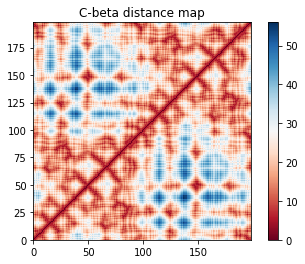

In [17]:
plt.pcolor(dist_matrix, cmap='RdBu')
plt.title('C-beta distance map')
plt.gca().set_aspect('equal')
plt.colorbar();

#### Calculate distance map for the protein dimer
Only consider distance <= 9. We use boolean indexing to set all distance > 9 to zero.

In [18]:
dist_matrix[dist_matrix > 9] = 0

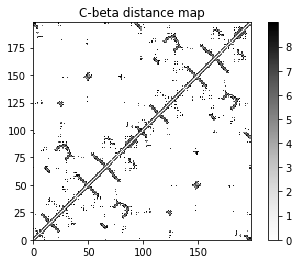

In [19]:
plt.pcolor(dist_matrix, cmap='Greys')
plt.title('C-beta distance map')
plt.gca().set_aspect('equal')
plt.colorbar();

In [20]:
spark.stop()